In [86]:
import pandas as pd
from monai.transforms import LoadImage
from monai.visualize import matshow3d
import matplotlib.pyplot as plt
import pydicom
import os
import numpy as np
from typing import Tuple
from pathlib import Path
import cv2
from skimage.exposure import match_histograms

In [143]:
def apply_dicom_windowing(img: np.ndarray, window_center: float, window_width: float, preserve_contrast=True) -> np.ndarray:
    img_min = window_center - window_width / 2
    img_max = window_center + window_width / 2
    img_clipped = np.clip(img, img_min, img_max)
    img_normalized = (img_clipped - img_min) / (img_max - img_min + 1e-7)
    img_processed = (img_normalized * 255).astype(np.uint8)
    if preserve_contrast:
        img_processed = cv2.equalizeHist(img_processed)
    return img_processed

def get_windowing_params(modality: str) -> Tuple[float, float]:
    return windows.get(modality, (40, 80))

def process_slice(img, ds):
    modality = getattr(ds, 'Modality', 'CT')
    if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
        img = img * ds.RescaleSlope + ds.RescaleIntercept
    window_center, window_width = get_windowing_params(modality)
    img = apply_dicom_windowing(img, window_center, window_width)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img



def process_dicom_series(uid: str):
    global label_df_global
    series_path = Path(f"{data_path}/series/{uid}")
    all_filepaths = sorted([
        os.path.join(root, file)
        for root, _, files in os.walk(series_path)
        for file in files if file.endswith('.dcm')
    ])

    if not all_filepaths:
        print(f"No DCM files found for {uid}")
        return np.array([]), []

    slices = []
    original = []
    instance_numbers = []

    for filepath in all_filepaths:
        ds = pydicom.dcmread(filepath, force=True)
        img = ds.pixel_array.astype(np.float32)

        if img.ndim == 3 and img.shape[-1] == 3:
            imgs = [cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2GRAY).astype(np.float32)]
        elif img.ndim == 3:
            imgs = list(img)
        else:
            imgs = [img]

        for img in imgs:
            if hasattr(ds, "InstanceNumber"):
                instance_numbers.append(ds.InstanceNumber)
            z_val = getattr(ds, "ImagePositionPatient", [0])[-1] if hasattr(ds, "ImagePositionPatient") else int(getattr(ds, "InstanceNumber", 0))
            slices.append((z_val, process_slice(img, ds)))
            original.append((z_val, img))
    return slices, original

In [65]:
df_train = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train.csv')
df_train_loc = pd.read_csv('/kaggle/input/rsna-intracranial-aneurysm-detection/train_localizers.csv')

In [150]:
IMG_SIZE = 512
FACTOR = 3
SEED = 42
N_FOLDS = 5
CORES = 16
windows = {
    'CT': (40, 80),
    'CTA': (50, 350),
    'MRA': (600, 1200),
    'MR': (600, 1200),
    'MRI': (40, 80),
    }
data_path = '/kaggle/input/rsna-intracranial-aneurysm-detection'
uid = '1.2.826.0.1.3680043.8.498.10752089895877999881724597742751706315'

In [151]:
slices, original = process_dicom_series(uid)

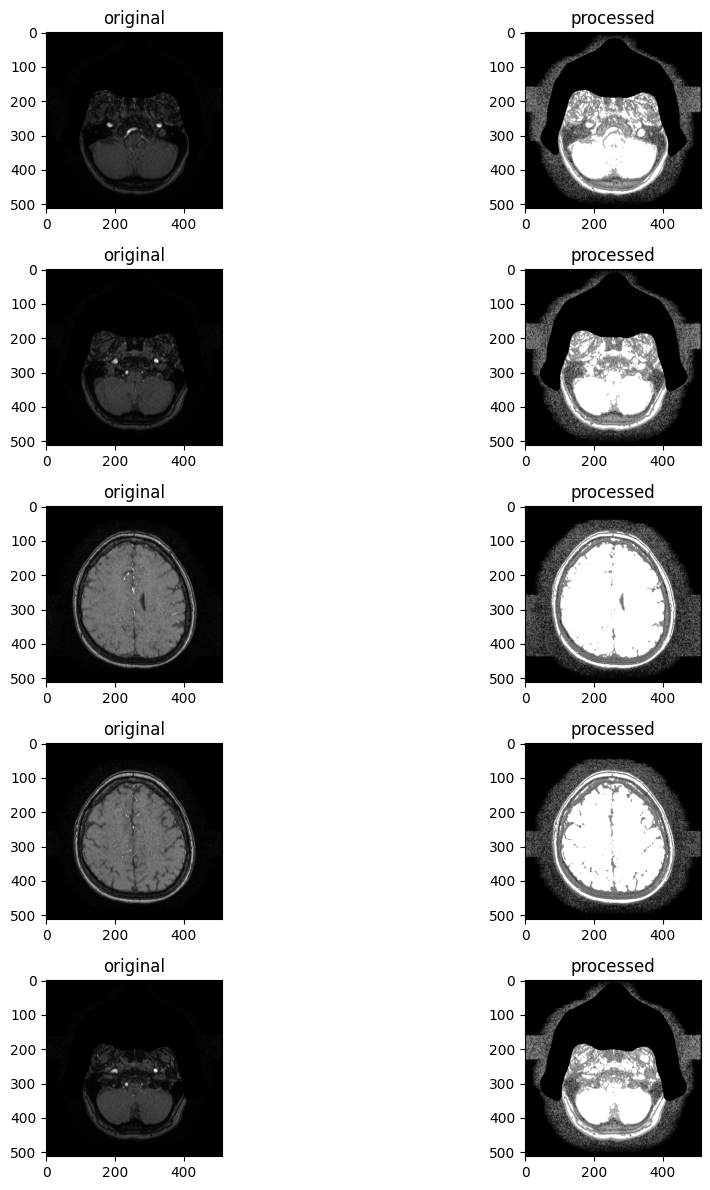

In [152]:
fig, ax = plt.subplots(ncols = 2, nrows = 5, figsize = (12, 12))
for i in range(5):
    ax[i, 0].imshow(original[i][1], cmap='gray')
    ax[i, 1].imshow(slices[i][1], cmap='gray')
    ax[i, 0].set_title('original')
    ax[i, 1].set_title('processed')
plt.tight_layout()

In [104]:
uid = '1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381'
file_path = f'/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/{uid}/{uid}.nii'
file_path_cowseg = f'/kaggle/input/rsna-intracranial-aneurysm-detection/segmentations/{uid}/{uid}_cowseg.nii'

In [105]:
df_meta = df_train[df_train.SeriesInstanceUID == uid].copy()
df_meta_loc = df_train_loc[df_train_loc.SeriesInstanceUID == uid].copy()

In [106]:
df_meta

,SeriesInstanceUID,PatientAge,PatientSex,Modality,Left Infraclinoid Internal Carotid Artery,Right Infraclinoid Internal Carotid Artery,Left Supraclinoid Internal Carotid Artery,Right Supraclinoid Internal Carotid Artery,Left Middle Cerebral Artery,Right Middle Cerebral Artery,Anterior Communicating Artery,Left Anterior Cerebral Artery,Right Anterior Cerebral Artery,Left Posterior Communicating Artery,Right Posterior Communicating Artery,Basilar Tip,Other Posterior Circulation,Aneurysm Present
13,1.2.826.0.1.3680043.8.498.10035643165968342618...,62,Female,CTA,0,0,0,1,1,0,0,0,1,0,0,0,0,1


In [107]:
loader = LoadImage(image_only=True)
image = loader(file_path)
image_cowseg = loader(file_path_cowseg)
print(image.shape)

torch.Size([512, 512, 228])


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


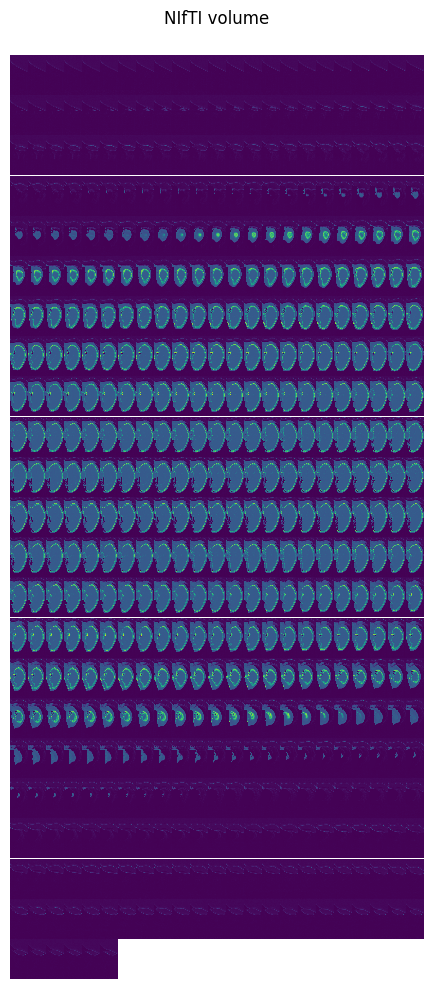

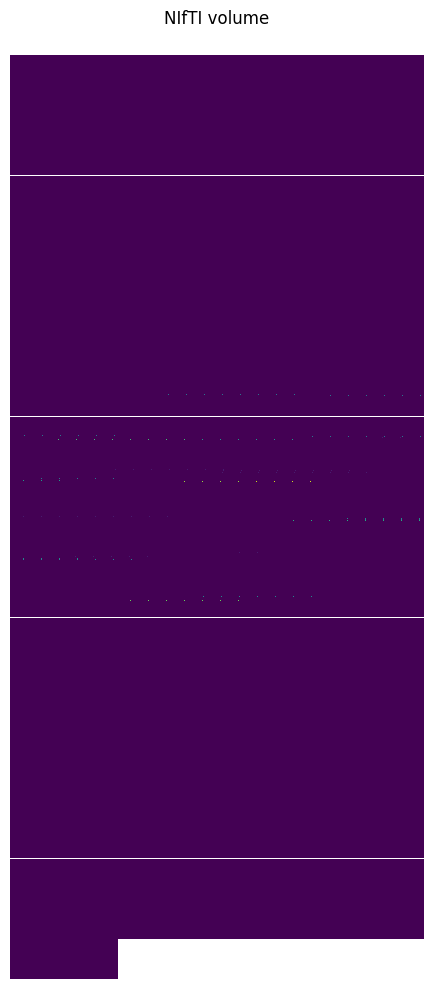

In [108]:
matshow3d(volume=image, title="NIfTI volume")
matshow3d(volume=image_cowseg, title="NIfTI volume")
plt.show()